In [1]:
  !git clone https://github.com/fulopjoz/pet-challenge-2025.git
  %cd /content/pet-challenge-2025

Cloning into 'pet-challenge-2025'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 59 (delta 6), reused 58 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 545.46 KiB | 2.66 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/pet-challenge-2025


# PET Challenge 2025 — Zero-Shot Prediction Pipeline

**Challenge**: [ALIGN Bio PET Challenge 2025](https://data.alignbio.org/tournament/predictive-phase), Zero-Shot Track  
**Goal**: Predict PETase enzyme **activity** and **expression** for 4988 variant sequences without training data  
**Metric**: NDCG (Normalized Discounted Cumulative Gain) — ranking quality  
**Targets**:
- `activity_1`, `activity_2`: specific activity (μmol TPA/min·mg enzyme) at pH 5.5 and pH 9.0
- `expression`: soluble expression level (mg/mL) in *E. coli* BL21(DE3)

## Approach

We use **protein language models (PLMs)** for zero-shot variant effect prediction:

| Model | Parameters | Package | Method |
|-------|-----------|---------|--------|
| ESM2-650M | 650M | `fair-esm` | WT-marginal scoring (Meier et al. 2021) |
| ESMC-600M | 600M | `esm` (EvolutionaryScale) | WT-marginal scoring |

Plus **ML baselines** (Ridge, RF, XGBoost) validated against 12 verified IsPETase Tm values from literature.

### Key References
- **Meier et al. (2021)** NeurIPS — WT-marginal scoring method for variant effects  
- **Lin et al. (2023)** Science — ESM2 language models  
- **EvolutionaryScale (2024)** — ESMC (ESM Cambrian)  
- **Král (2025)** MSc Thesis, Charles University — PLM score combination for thermostability  
- **Brott et al. (2022)** Eng. Life Sci. — IsPETase Tm measurements (nanoDSF)  
- **Lu et al. (2022)** Nature — FAST-PETase (ML-designed)


---
## 1. Setup & Environment

**Important**: Select **GPU runtime** in Colab: Runtime → Change runtime type → T4 GPU

We install `fair-esm` (for ESM2) and `esm` (for ESMC) in sequence because they share the `esm` Python namespace.  
ESM2 scoring runs first with `fair-esm`, then we install the EvolutionaryScale `esm` package for ESMC.

In [2]:
# Core dependencies (always needed)
!pip install -q numpy pandas scipy scikit-learn xgboost matplotlib seaborn joblib

import torch
import os
import sys

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  NO GPU DETECTED — Go to Runtime → Change runtime type → T4 GPU")
    print("    CPU-only will be very slow (~1 hour instead of ~5 minutes)")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
VRAM: 15.6 GB


In [3]:
# Set project root — handles Colab's /content/ path automatically
# If running from within the cloned repo:
if os.path.exists('data/petase_challenge_data'):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists('pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)
elif os.path.exists('/content/pet-challenge-2025/data/petase_challenge_data'):
    # Google Colab default clone location
    PROJECT_ROOT = '/content/pet-challenge-2025'
    os.chdir(PROJECT_ROOT)
else:
    # Clone the repo
    !git clone https://github.com/fulopjoz/pet-challenge-2025.git
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"Working dir:  {os.getcwd()}")

# Verify ALL required files exist
required_files = [
    'data/petase_challenge_data/pet-2025-wildtype-cds.csv',
    'data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv',
    'data/mutations_dataset.csv',
    'data/features_matrix.csv',
    'scripts/esm2_zero_shot_scoring.py',
    'scripts/esmc_scoring.py',
    'scripts/generate_submission.py',
    'scripts/validate_scores.py',
]
all_ok = True
for f in required_files:
    path = os.path.join(PROJECT_ROOT, f)
    if os.path.exists(path):
        size_kb = os.path.getsize(path) / 1024
        print(f"  OK: {f} ({size_kb:.0f} KB)")
    else:
        print(f"  MISSING: {f}")
        all_ok = False

if all_ok:
    print("\nAll files present!")
else:
    print("\nSome files missing — check your clone or upload")

# Make results directory
os.makedirs(os.path.join(PROJECT_ROOT, 'results'), exist_ok=True)

Project root: /content/pet-challenge-2025
Working dir:  /content/pet-challenge-2025
  OK: data/petase_challenge_data/pet-2025-wildtype-cds.csv (302 KB)
  OK: data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv (1274 KB)
  OK: data/mutations_dataset.csv (2 KB)
  OK: data/features_matrix.csv (7 KB)
  OK: scripts/esm2_zero_shot_scoring.py (12 KB)
  OK: scripts/esmc_scoring.py (12 KB)
  OK: scripts/generate_submission.py (7 KB)
  OK: scripts/validate_scores.py (11 KB)

All files present!


---
## 2. Data Exploration

The challenge provides:
- **313 wild-type PETase sequences** (diverse scaffolds, lengths 183-266 aa)
- **4988 test sequences** to predict: 314 WT-identical + 4674 single-point mutants
- **Expression system**: pET28a vector, BL21(DE3), IMAC purification, 6xHis tag
- **Activity assay**: Powdered PET substrate, 30°C, mass spec detection of TPA
  - `activity_1`: pH 5.5 (citrate buffer)
  - `activity_2`: pH 9.0 (glycine-NaOH buffer)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Load data
wt_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data/petase_challenge_data/pet-2025-wildtype-cds.csv'))
test_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv'))

print(f"Wild-type sequences: {len(wt_df)}")
print(f"Test sequences: {len(test_df)}")
print(f"\nWT columns: {list(wt_df.columns)}")
print(f"Test columns: {list(test_df.columns)}")

Wild-type sequences: 313
Test sequences: 4988

WT columns: ['Wt AA Sequence', 'CDS']
Test columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']


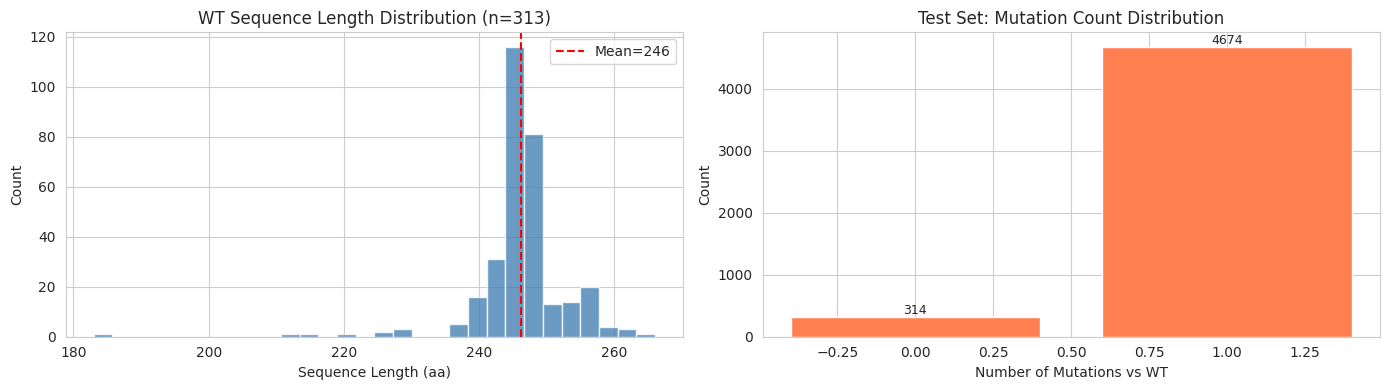


WT-identical: 314 (6.3%)
Single mutants: 4674 (93.7%)


In [5]:
# Analyze WT sequence diversity
wt_seqs = list(wt_df['Wt AA Sequence'].values)
wt_lengths = [len(s) for s in wt_seqs]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# WT length distribution
axes[0].hist(wt_lengths, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Sequence Length (aa)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'WT Sequence Length Distribution (n={len(wt_seqs)})')
axes[0].axvline(np.mean(wt_lengths), color='red', ls='--', label=f'Mean={np.mean(wt_lengths):.0f}')
axes[0].legend()

# Map test sequences to WTs and count mutations
wt_by_len = defaultdict(list)
for i, seq in enumerate(wt_seqs):
    wt_by_len[len(seq)].append((i, seq))

test_n_muts = []
test_wt_idx = []
for test_seq in test_df['sequence'].values:
    tlen = len(test_seq)
    best_wt, best_diff = None, 999
    for wi, wseq in wt_by_len.get(tlen, []):
        ndiff = sum(1 for a, b in zip(wseq, test_seq) if a != b)
        if ndiff < best_diff:
            best_diff = ndiff
            best_wt = wi
        if ndiff == 0:
            break
    test_n_muts.append(best_diff)
    test_wt_idx.append(best_wt)

# Mutation count distribution
mut_counts = Counter(test_n_muts)
axes[1].bar(mut_counts.keys(), mut_counts.values(), color='coral', edgecolor='white')
axes[1].set_xlabel('Number of Mutations vs WT')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set: Mutation Count Distribution')
for k, v in sorted(mut_counts.items()):
    axes[1].text(k, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nWT-identical: {mut_counts[0]} ({mut_counts[0]/len(test_df)*100:.1f}%)")
print(f"Single mutants: {mut_counts.get(1,0)} ({mut_counts.get(1,0)/len(test_df)*100:.1f}%)")

In [6]:
# Which WTs have the most variants?
wt_variant_counts = Counter(test_wt_idx)
top_wts = wt_variant_counts.most_common(10)

print("Top 10 WT scaffolds by number of test variants:")
print(f"{'WT Index':<10} {'Variants':<10} {'Length':<10} {'% of Test Set':<15}")
print("-" * 45)
for wi, count in top_wts:
    print(f"{wi:<10} {count:<10} {len(wt_seqs[wi]):<10} {count/len(test_df)*100:.1f}%")

# The 3 main scaffolds cover almost all variants
top3_total = sum(c for _, c in top_wts[:3])
print(f"\nTop 3 scaffolds cover {top3_total}/{len(test_df)} ({top3_total/len(test_df)*100:.1f}%) of test set")

Top 10 WT scaffolds by number of test variants:
WT Index   Variants   Length     % of Test Set  
---------------------------------------------
0          1560       259        31.3%
1          1559       257        31.3%
2          1559       259        31.3%
3          1          245        0.0%
4          1          242        0.0%
5          1          249        0.0%
6          1          245        0.0%
7          1          242        0.0%
8          1          244        0.0%
9          1          245        0.0%

Top 3 scaffolds cover 4678/4988 (93.8%) of test set


---
## 3. Approach 1: ESM2-650M Zero-Shot Scoring

### Method: Wildtype-Marginal Scoring

For each WT, we run a **single forward pass** through ESM2 and extract the predicted probability distribution at every position. For a mutation at position *i* from amino acid *w* to *m*:

$$\Delta LL = \log P(m | \text{context}) - \log P(w | \text{context})$$

This captures how "tolerated" the mutation is according to the model's evolutionary knowledge.  
Positive $\Delta LL$ = mutation is preferred over wildtype (rare, ~0.8% of mutations).  
Negative $\Delta LL$ = mutation is deleterious (common, ~99.2%).

We also compute auxiliary scores per [Král (2025)](https://dspace.cuni.cz/):
- **abs_ll**: mean log P(native aa) — absolute sequence fitness
- **entropy**: mean positional entropy — lower = more conserved positions
- **logit_native**: mean raw logit for native residue — model confidence
- **joint_ll**: joint log-likelihood over all standard AAs

**Why ESM2-650M?** Top performer on [ProteinGym](https://proteingym.org/) zero-shot benchmarks.  
650M parameters, 33 layers, trained on 250M protein sequences (UniRef50).

In [7]:
# Install fair-esm for ESM2
!pip install -q fair-esm

# Verify import
import importlib
if 'esm' in sys.modules:
    del sys.modules['esm']
import esm
print(f"ESM package loaded: {esm.__file__}")
print(f"ESM2-650M available: {hasattr(esm.pretrained, 'esm2_t33_650M_UR50D')}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.1 MB/s eta 0:00:00
ESM package loaded: /usr/local/lib/python3.12/dist-packages/esm/__init__.py
ESM2-650M available: True


In [8]:
# Run ESM2 scoring script
# This scores all 313 WTs (one forward pass each) and derives scores for 4988 variants
# Runtime: ~5 min on T4 GPU, ~20 min on CPU

esm2_scores_path = os.path.join(PROJECT_ROOT, 'results', 'esm2_scores.csv')

if os.path.exists(esm2_scores_path):
    print(f"ESM2 scores already exist at {esm2_scores_path}")
    print("Delete the file and re-run this cell to regenerate.")
else:
    %run scripts/esm2_zero_shot_scoring.py

ESM2 scores already exist at /content/pet-challenge-2025/results/esm2_scores.csv
Delete the file and re-run this cell to regenerate.


In [9]:
# Load and visualize ESM2 scores
esm2_scores = pd.read_csv(esm2_scores_path)
print(f"ESM2 scores: {len(esm2_scores)} rows")
print(f"Columns: {list(esm2_scores.columns)}")
esm2_scores.head()

ESM2 scores: 4988 rows
Columns: ['test_idx', 'wt_idx', 'n_mutations', 'delta_ll', 'abs_ll', 'wt_abs_ll', 'entropy', 'logit_native', 'joint_ll']


,test_idx,wt_idx,n_mutations,delta_ll,abs_ll,wt_abs_ll,entropy,logit_native,joint_ll
0,0,0,1,-6.245117,-0.294539,-0.270427,0.548766,6.583791,-156.700897
1,1,0,1,-10.523438,-0.311058,-0.270427,0.548766,6.583791,-156.700897
2,2,0,1,-9.470703,-0.306993,-0.270427,0.548766,6.583791,-156.700897
3,3,0,1,-9.644531,-0.307664,-0.270427,0.548766,6.583791,-156.700897
4,4,0,1,-7.459473,-0.299228,-0.270427,0.548766,6.583791,-156.700897


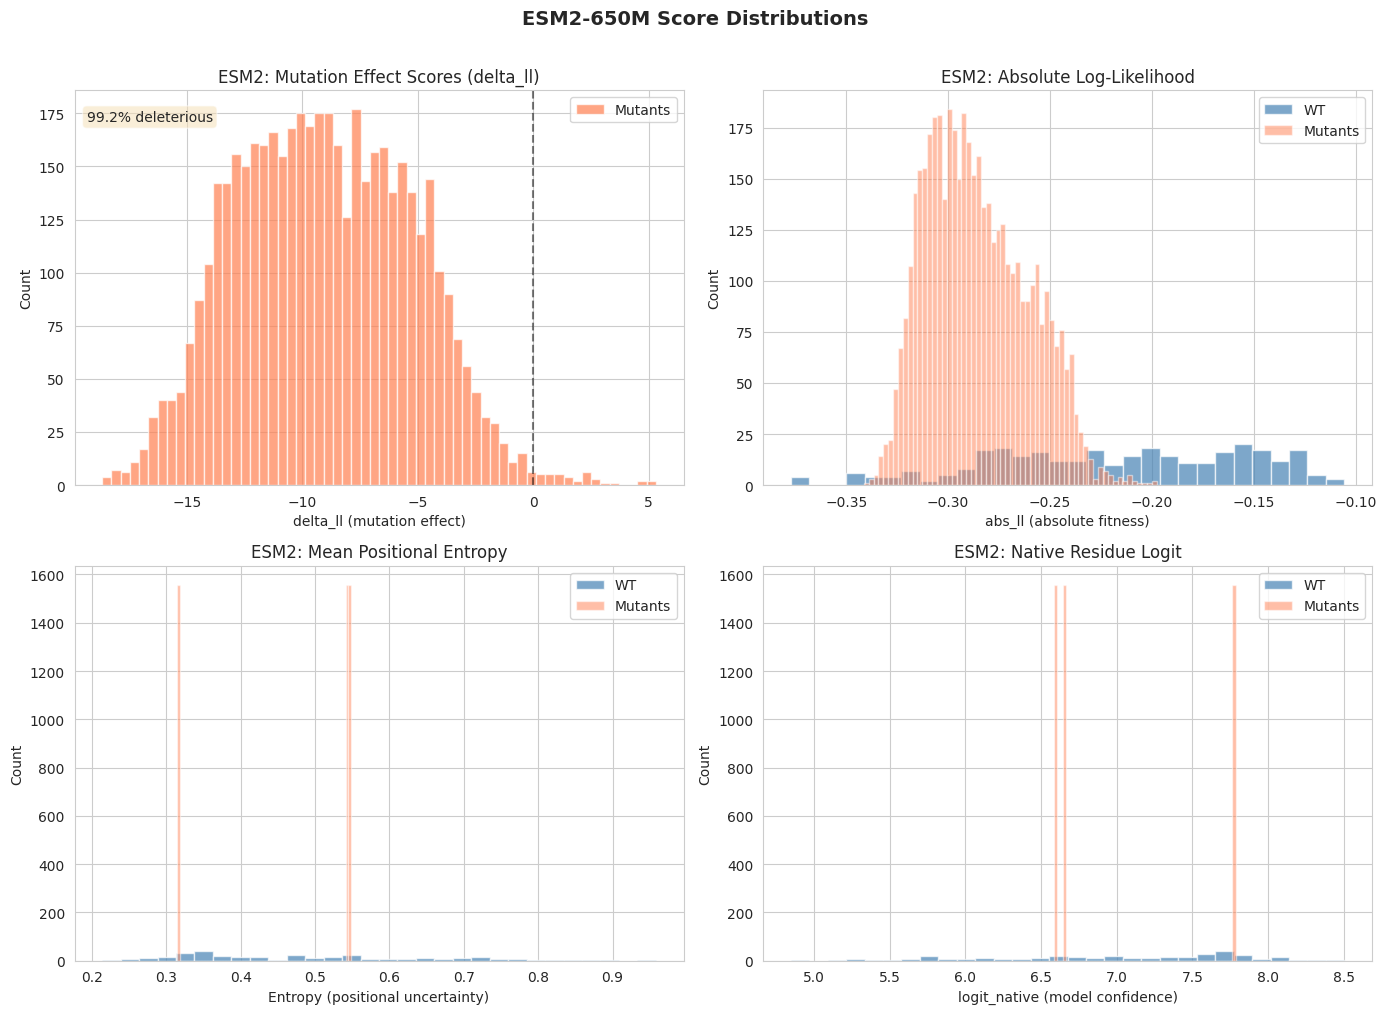

In [10]:
# ESM2 score distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

wt_mask = esm2_scores['n_mutations'] == 0
mut_mask = esm2_scores['n_mutations'] == 1

# delta_ll distribution
ax = axes[0, 0]
ax.hist(esm2_scores.loc[mut_mask, 'delta_ll'], bins=60, alpha=0.7, color='coral', label='Mutants', edgecolor='white')
ax.axvline(0, color='black', ls='--', alpha=0.5)
ax.set_xlabel('delta_ll (mutation effect)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Mutation Effect Scores (delta_ll)')
frac_neg = (esm2_scores.loc[mut_mask, 'delta_ll'] < 0).mean()
ax.text(0.02, 0.95, f'{frac_neg*100:.1f}% deleterious', transform=ax.transAxes,
        fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()

# abs_ll: WT vs mutant
ax = axes[0, 1]
ax.hist(esm2_scores.loc[wt_mask, 'abs_ll'], bins=30, alpha=0.7, color='steelblue', label='WT', edgecolor='white')
ax.hist(esm2_scores.loc[mut_mask, 'abs_ll'], bins=60, alpha=0.5, color='coral', label='Mutants', edgecolor='white')
ax.set_xlabel('abs_ll (absolute fitness)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Absolute Log-Likelihood')
ax.legend()

# entropy distribution
ax = axes[1, 0]
ax.hist(esm2_scores.loc[wt_mask, 'entropy'], bins=30, alpha=0.7, color='steelblue', label='WT', edgecolor='white')
ax.hist(esm2_scores.loc[mut_mask, 'entropy'], bins=60, alpha=0.5, color='coral', label='Mutants', edgecolor='white')
ax.set_xlabel('Entropy (positional uncertainty)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Mean Positional Entropy')
ax.legend()

# logit_native
ax = axes[1, 1]
ax.hist(esm2_scores.loc[wt_mask, 'logit_native'], bins=30, alpha=0.7, color='steelblue', label='WT', edgecolor='white')
ax.hist(esm2_scores.loc[mut_mask, 'logit_native'], bins=60, alpha=0.5, color='coral', label='Mutants', edgecolor='white')
ax.set_xlabel('logit_native (model confidence)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Native Residue Logit')
ax.legend()

plt.suptitle('ESM2-650M Score Distributions', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

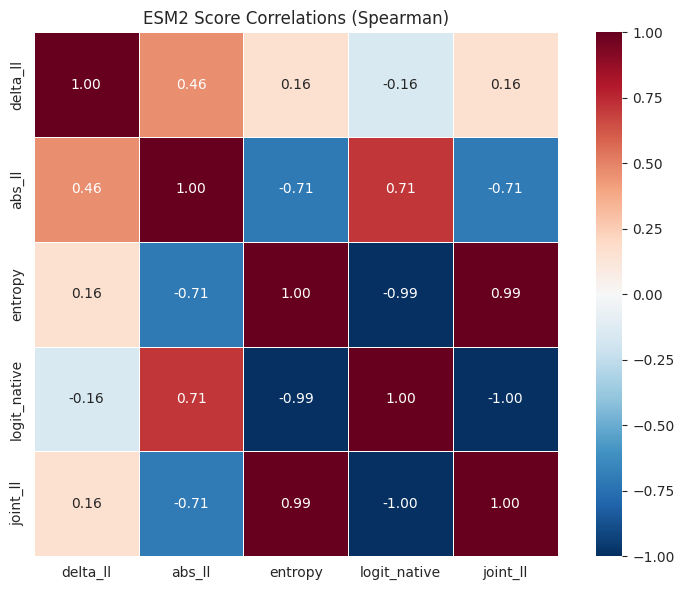

In [11]:
# Score correlation heatmap (ESM2)
score_cols = ['delta_ll', 'abs_ll', 'entropy', 'logit_native', 'joint_ll']
corr_matrix = esm2_scores[score_cols].astype(float).corr(method='spearman')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('ESM2 Score Correlations (Spearman)', fontsize=12)
plt.tight_layout()
plt.show()

---
## 4. Approach 2: ESMC-600M Zero-Shot Scoring

**ESMC (ESM Cambrian)** is EvolutionaryScale's 2024 model that rivals ESM2-3B with only 600M parameters.  
In [Král (2025)](https://dspace.cuni.cz/), ESMC-300M achieved the best zero-shot Spearman correlation (ρ=0.49) on antibody thermostability.

We use the same WT-marginal scoring method as ESM2 but with a different model architecture.

**Note**: `fair-esm` and `esm` (EvolutionaryScale) share the `esm` Python namespace.  
We install the EvolutionaryScale package here, which overwrites the `fair-esm` module.  
ESM2 scores were already saved to CSV, so no data is lost.

In [12]:
# Install EvolutionaryScale's esm package for ESMC
# This overwrites fair-esm's 'esm' module — ESM2 scores are already saved
!pip install -q esm

# Force reimport
for mod_name in list(sys.modules.keys()):
    if 'esm' in mod_name:
        del sys.modules[mod_name]

from esm.models.esmc import ESMC
print("ESMC loaded successfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 M

In [13]:
# Run ESMC scoring
# Runtime: ~5 min on T4 GPU

esmc_scores_path = os.path.join(PROJECT_ROOT, 'results', 'esmc_scores.csv')

if os.path.exists(esmc_scores_path):
    print(f"ESMC scores already exist at {esmc_scores_path}")
    print("Delete the file and re-run this cell to regenerate.")
else:
    # Run the ESMC scoring script
    # Note: on Colab, we run it as a subprocess to handle the module reload cleanly
    import subprocess
    result = subprocess.run(
        [sys.executable, os.path.join(PROJECT_ROOT, 'scripts', 'esmc_scoring.py')],
        capture_output=True, text=True, cwd=PROJECT_ROOT
    )
    print(result.stdout)
    if result.returncode != 0:
        print("STDERR:", result.stderr)

Loading data...
  313 wild-type sequences
  4988 test sequences
Mapping test sequences to wild-types...
  WT-identical: 314, single-mutant: 4674, other: 0
  Need to score 313 unique WTs
Loading esmc_600m...
Model loaded on cuda (half=True)
  AA token map built (20 amino acids)

Scoring 313 wild-type sequences on cuda...

STDERR: 
Fetching 4 files: 100%|██████████| 4/4 [00:26<00:00,  6.63s/it]
Traceback (most recent call last):
  File "/content/pet-challenge-2025/scripts/esmc_scoring.py", line 361, in <module>
    main()
  File "/content/pet-challenge-2025/scripts/esmc_scoring.py", line 258, in main
    log_probs, logits_raw, probs = score_sequence_esmc(
                                   ^^^^^^^^^^^^^^^^^^^^
  File "/content/pet-challenge-2025/scripts/esmc_scoring.py", line 127, in score_sequence_esmc
    if logits.dim() == 3:
       ^^^^^^^^^^
AttributeError: 'ForwardTrackData' object has no attribute 'dim'



In [14]:
# Load and visualize ESMC scores (if available)
if os.path.exists(esmc_scores_path):
    esmc_scores = pd.read_csv(esmc_scores_path)
    print(f"ESMC scores: {len(esmc_scores)} rows")

    # Compare ESM2 vs ESMC
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    from scipy import stats

    for i, col in enumerate(['delta_ll', 'abs_ll', 'entropy']):
        ax = axes[i]
        v1 = esm2_scores[col].astype(float).values
        v2 = esmc_scores[col].astype(float).values
        rho, pval = stats.spearmanr(v1, v2)

        ax.scatter(v1, v2, s=1, alpha=0.3, c='steelblue')
        ax.set_xlabel(f'ESM2 {col}')
        ax.set_ylabel(f'ESMC {col}')
        ax.set_title(f'{col}\nSpearman ρ = {rho:.3f}')
        # Add diagonal
        lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
                max(ax.get_xlim()[1], ax.get_ylim()[1])]
        ax.plot(lims, lims, 'r--', alpha=0.3)

    plt.suptitle('ESM2 vs ESMC Score Agreement', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("ESMC scores not available yet. Run the ESMC scoring cell above.")
    esmc_scores = None

ESMC scores not available yet. Run the ESMC scoring cell above.


---
## 5. ML Baselines — Validated on Known Tm Data

We have **12 verified IsPETase Tm values** from 4 published papers:

| Source | Variants | Method |
|--------|----------|--------|
| Brott et al. 2022, Eng. Life Sci. | 7 (WT → DuraPETase+SS) | nanoDSF |
| Lu et al. 2022, Nature | 1 (FAST-PETase) | DSF |
| Son et al. 2019, ACS Catal | 2 (WT, ThermoPETase) | DSF |
| Cui et al. 2021, ACS Catal | 2 (WT, DuraPETase) | DSF |

These serve as ground truth to validate our feature extraction and ML models.  
The models are NOT used for the challenge submission (wrong target: Tm ≠ activity/expression),  
but they validate that our sequence features capture meaningful structural information.

### 37 Sequence Features
- **AA composition** (20): Frequency of each amino acid
- **Physicochemical** (7): MW, GRAVY, charge, aromatic%, GlyPro%, length, Cys count
- **Active-site distance** (3): Min distance from mutations to catalytic triad (Ser160, Asp206, His237)
- **Mutation statistics** (3): N_mutations, mutation span, mean position
- **Structural proxies** (4): Helix/beta propensity, N/C-terminal aromatic%

In [15]:
# Load or generate Tm dataset
mutations_path = os.path.join(PROJECT_ROOT, 'data', 'mutations_dataset.csv')
features_path = os.path.join(PROJECT_ROOT, 'data', 'features_matrix.csv')

if not os.path.exists(mutations_path):
    %run scripts/extract_mutations.py

if not os.path.exists(features_path):
    %run scripts/feature_extraction.py

# Load and display
tm_df = pd.read_csv(mutations_path)
features_df = pd.read_csv(features_path)

print(f"Tm dataset: {len(tm_df)} entries")
print(f"Feature matrix: {features_df.shape}")

# Show the verified Tm data
ispetase = tm_df[tm_df['enzyme'] == 'IsPETase']
print(f"\nIsPETase variants ({len(ispetase)}) with verified Tm:")
for _, row in ispetase.iterrows():
    n_mut = 0 if row['mutation'] == 'WT' else len(row['mutation'].split('/'))
    print(f"  {row['variant_name']:25s}  {n_mut} mut  Tm={row['tm']:5.1f}°C  ({row['source'][:20]}...)")

Tm dataset: 14 entries
Feature matrix: (12, 39)

IsPETase variants (12) with verified Tm:
  WT                         0 mut  Tm= 45.1°C  (Brott 2022 (DOI: 10....)
  ThermoPETase               3 mut  Tm= 56.6°C  (Brott 2022 (DOI: 10....)
  ThermoPETase+KF            5 mut  Tm= 61.6°C  (Brott 2022 (DOI: 10....)
  ThermoPETase+SS            5 mut  Tm= 68.2°C  (Brott 2022 (DOI: 10....)
  ThermoPETase+KF+SS         7 mut  Tm= 70.8°C  (Brott 2022 (DOI: 10....)
  DuraPETase                 9 mut  Tm= 75.0°C  (Brott 2022 (DOI: 10....)
  DuraPETase+SS              11 mut  Tm= 81.1°C  (Brott 2022 (DOI: 10....)
  FAST-PETase                5 mut  Tm= 67.8°C  (Lu 2022 (DOI: 10.103...)
  WT (Son)                   0 mut  Tm= 46.1°C  (Son 2019 (DOI: 10.10...)
  ThermoPETase (Son)         3 mut  Tm= 54.9°C  (Son 2019 (DOI: 10.10...)
  WT (Cui)                   0 mut  Tm= 46.0°C  (Cui 2021 (DOI: 10.10...)
  DuraPETase (Cui)           9 mut  Tm= 77.0°C  (Cui 2021 (DOI: 10.10...)


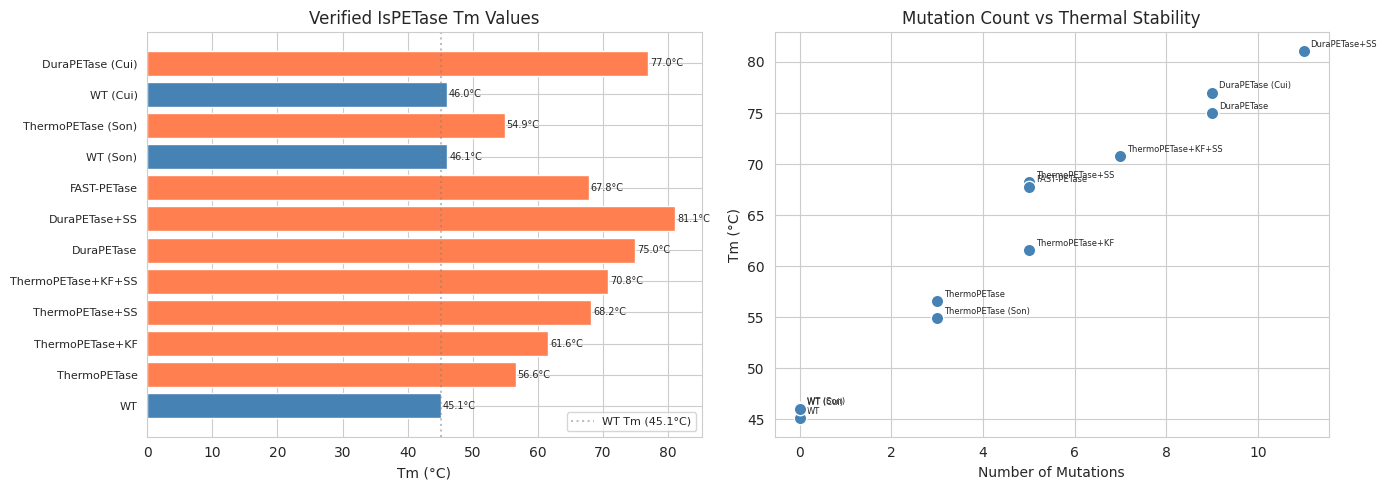

In [16]:
# Visualize Tm data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tm values bar chart
ax = axes[0]
colors = ['steelblue' if 'WT' in name else 'coral' for name in ispetase['variant_name']]
bars = ax.barh(range(len(ispetase)), ispetase['tm'].values, color=colors, edgecolor='white')
ax.set_yticks(range(len(ispetase)))
ax.set_yticklabels(ispetase['variant_name'].values, fontsize=8)
ax.set_xlabel('Tm (°C)')
ax.set_title('Verified IsPETase Tm Values')
ax.axvline(45.1, color='gray', ls=':', alpha=0.5, label='WT Tm (45.1°C)')
ax.legend(fontsize=8)
for i, (_, row) in enumerate(ispetase.iterrows()):
    ax.text(row['tm'] + 0.3, i, f"{row['tm']:.1f}°C", va='center', fontsize=7)

# N_mutations vs Tm
ax = axes[1]
n_muts = []
for _, row in ispetase.iterrows():
    n_muts.append(0 if row['mutation'] == 'WT' else len(row['mutation'].split('/')))
ax.scatter(n_muts, ispetase['tm'].values, s=80, c='steelblue', edgecolors='white', zorder=5)
for i, (_, row) in enumerate(ispetase.iterrows()):
    ax.annotate(row['variant_name'], (n_muts[i], row['tm']),
                fontsize=6, xytext=(5, 3), textcoords='offset points')
ax.set_xlabel('Number of Mutations')
ax.set_ylabel('Tm (°C)')
ax.set_title('Mutation Count vs Thermal Stability')

plt.tight_layout()
plt.show()

In [17]:
# Train ML models on Tm data
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

# Prepare data
feature_names = [c for c in features_df.columns if c not in ['variant_name', 'Tm']]
X = features_df[feature_names].values.astype(float)
y = features_df['Tm'].values.astype(float)
names = features_df['variant_name'].values

print(f"Training data: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Tm range: {y.min():.1f} - {y.max():.1f}°C (span: {y.max()-y.min():.1f}°C)")

# Define models
models = {
    'Ridge (α=1)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5,
                                           min_samples_split=3, min_samples_leaf=2, random_state=42),
}

try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1,
                                          reg_alpha=1.0, reg_lambda=1.0, random_state=42, verbosity=0)
except ImportError:
    pass

# LOOCV evaluation
loo = LeaveOneOut()
results = []
predictions = {}

for name_m, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=loo)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    rho, _ = spearmanr(y, y_pred)

    results.append({'Model': name_m, 'LOOCV_RMSE': rmse, 'LOOCV_R2': r2, 'Spearman': rho})
    predictions[name_m] = y_pred

results_df = pd.DataFrame(results).sort_values('LOOCV_RMSE')
print("\nModel Comparison (Leave-One-Out Cross-Validation):")
print(results_df.to_string(index=False, float_format='{:.3f}'.format))

Training data: 12 samples, 37 features
Tm range: 45.1 - 81.1°C (span: 36.0°C)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e-01, tolerance: 1.448e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.029e-01, tolerance: 1.741e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.562e-01, tolerance: 1.778e


Model Comparison (Leave-One-Out Cross-Validation):
        Model  LOOCV_RMSE  LOOCV_R2  Spearman
   ElasticNet       1.597     0.983     0.958
Lasso (α=0.1)       1.659     0.981     0.937
 Ridge (α=10)       1.808     0.978     0.958
  Ridge (α=1)       2.158     0.969     0.958
Random Forest       4.899     0.838     0.986
      XGBoost       5.006     0.831     0.881


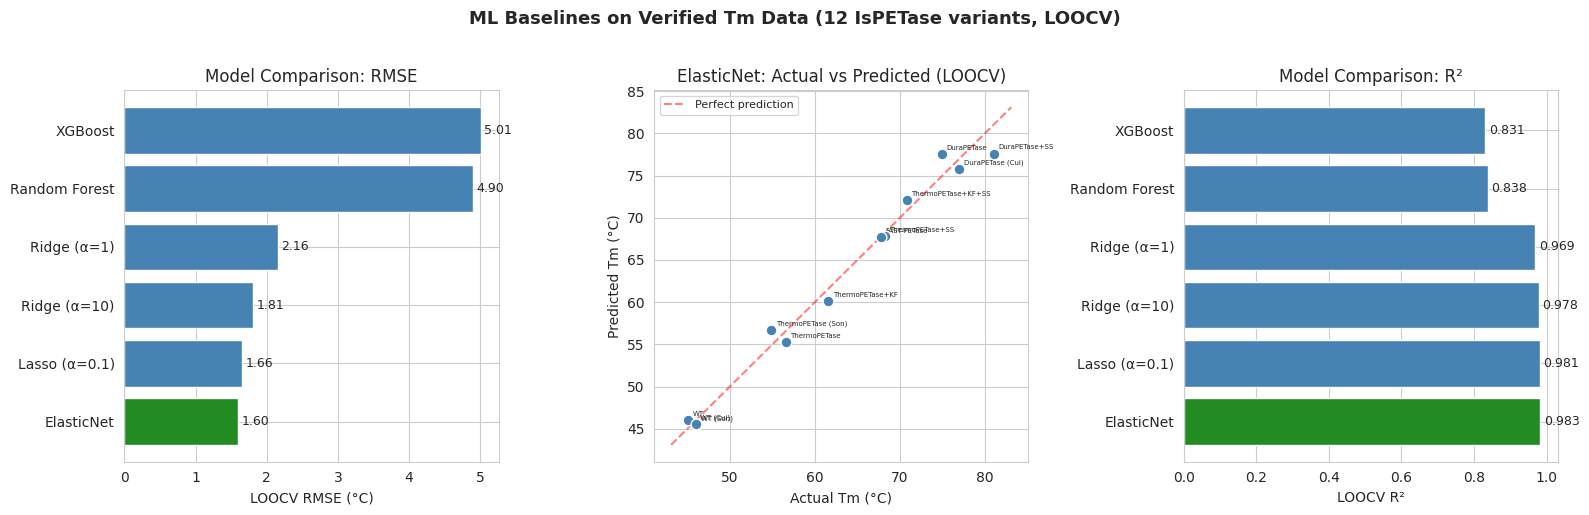

In [18]:
# Visualize ML model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE comparison
ax = axes[0]
colors_ml = ['forestgreen' if r['LOOCV_RMSE'] == results_df['LOOCV_RMSE'].min() else 'steelblue'
             for _, r in results_df.iterrows()]
ax.barh(range(len(results_df)), results_df['LOOCV_RMSE'].values, color=colors_ml, edgecolor='white')
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Model'].values)
ax.set_xlabel('LOOCV RMSE (°C)')
ax.set_title('Model Comparison: RMSE')
for i, rmse in enumerate(results_df['LOOCV_RMSE'].values):
    ax.text(rmse + 0.05, i, f'{rmse:.2f}', va='center', fontsize=9)

# Best model: actual vs predicted
best_model_name = results_df.iloc[0]['Model']
best_pred = predictions[best_model_name]
ax = axes[1]
ax.scatter(y, best_pred, s=60, c='steelblue', edgecolors='white', zorder=5)
for i in range(len(y)):
    ax.annotate(names[i], (y[i], best_pred[i]), fontsize=5, xytext=(3, 3), textcoords='offset points')
lims = [min(y.min(), best_pred.min()) - 2, max(y.max(), best_pred.max()) + 2]
ax.plot(lims, lims, 'r--', alpha=0.5, label='Perfect prediction')
ax.set_xlabel('Actual Tm (°C)')
ax.set_ylabel('Predicted Tm (°C)')
ax.set_title(f'{best_model_name}: Actual vs Predicted (LOOCV)')
ax.legend(fontsize=8)

# R² comparison
ax = axes[2]
colors_r2 = ['forestgreen' if r['LOOCV_R2'] == results_df['LOOCV_R2'].max() else 'steelblue'
             for _, r in results_df.iterrows()]
ax.barh(range(len(results_df)), results_df['LOOCV_R2'].values, color=colors_r2, edgecolor='white')
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Model'].values)
ax.set_xlabel('LOOCV R²')
ax.set_title('Model Comparison: R²')
ax.axvline(0, color='gray', ls=':', alpha=0.5)
for i, r2 in enumerate(results_df['LOOCV_R2'].values):
    ax.text(max(r2 + 0.01, 0.01), i, f'{r2:.3f}', va='center', fontsize=9)

plt.suptitle('ML Baselines on Verified Tm Data (12 IsPETase variants, LOOCV)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Validation & Sanity Checks

Since we have no ground truth for the 4988 challenge sequences, we validate using **biological priors**:

1. **WT > mutants on abs_ll**: Wild-type is the evolutionary optimum → highest fitness
2. **Most mutations deleterious**: >50% of random mutations should have negative delta_ll
3. **Score variance**: Non-degenerate distributions (models actually discriminate)
4. **Cross-model agreement**: ESM2 and ESMC should largely agree on rankings
5. **ML baselines**: Positive R² on known Tm data confirms features capture structure

In [19]:
# Comprehensive validation
print("=" * 60)
print("VALIDATION REPORT")
print("=" * 60)

all_checks = []

# Check 1: WT abs_ll > mutant abs_ll
wt_abs = esm2_scores.loc[esm2_scores['n_mutations'] == 0, 'abs_ll'].astype(float).mean()
mut_abs = esm2_scores.loc[esm2_scores['n_mutations'] == 1, 'abs_ll'].astype(float).mean()
check1 = wt_abs > mut_abs
all_checks.append(('WT abs_ll > mutant abs_ll', check1, f'{wt_abs:.4f} > {mut_abs:.4f}'))

# Check 2: Most mutations deleterious
frac_neg = (esm2_scores.loc[esm2_scores['n_mutations'] == 1, 'delta_ll'].astype(float) < 0).mean()
check2 = frac_neg > 0.5
all_checks.append(('Most mutations deleterious (>50%)', check2, f'{frac_neg*100:.1f}% negative'))

# Check 3: Score variance
delta_std = esm2_scores['delta_ll'].astype(float).std()
check3 = delta_std > 0.1
all_checks.append(('delta_ll has variance (std > 0.1)', check3, f'std = {delta_std:.4f}'))

# Check 4: ML baseline positive R²
best_r2 = results_df['LOOCV_R2'].max()
check4 = best_r2 > 0.0
all_checks.append(('ML baseline R² > 0 on Tm data', check4, f'best R² = {best_r2:.3f}'))

# Check 5: Cross-model agreement (if ESMC available)
if esmc_scores is not None:
    rho_delta, _ = spearmanr(
        esm2_scores['delta_ll'].astype(float),
        esmc_scores['delta_ll'].astype(float)
    )
    check5 = rho_delta > 0.3
    all_checks.append(('ESM2-ESMC agreement (ρ > 0.3)', check5, f'ρ = {rho_delta:.3f}'))

print(f"\n{'Check':<45} {'Status':<8} {'Detail'}")
print("-" * 80)
for name, passed, detail in all_checks:
    status = 'PASS' if passed else 'FAIL'
    print(f"  {name:<43} {status:<8} {detail}")

n_pass = sum(1 for _, p, _ in all_checks if p)
print(f"\nResult: {n_pass}/{len(all_checks)} checks passed")

VALIDATION REPORT

Check                                         Status   Detail
--------------------------------------------------------------------------------
  WT abs_ll > mutant abs_ll                   PASS     -0.2176 > -0.2856
  Most mutations deleterious (>50%)           PASS     99.2% negative
  delta_ll has variance (std > 0.1)           PASS     std = 4.2695
  ML baseline R² > 0 on Tm data               PASS     best R² = 0.983

Result: 4/4 checks passed


---
## 7. Generate Final Submission

### Score Combination Strategy

Per target, we combine z-scored PLM scores with different weights:

**Activity** (mutation tolerance → enzyme function):  
`0.5 * z(delta_ll) + 0.3 * z(abs_ll) + 0.1 * z(-entropy) + 0.1 * z(logit_native)`

**Expression** (protein stability → foldability → expressibility):  
`0.2 * z(delta_ll) + 0.4 * z(abs_ll) + 0.2 * z(-entropy) + 0.2 * z(logit_native)`

**Rationale** (from literature):
- `delta_ll` is the primary signal for mutation effects on **activity** — how much the mutation disrupts the active site
- `abs_ll` better predicts **expression** — it captures overall protein fitness/foldability which correlates with soluble expression in *E. coli*
- Entropy and logit_native provide additional evolutionary conservation signal
- Weights inspired by Král (2025) ZS3 formula for thermostability

If both ESM2 and ESMC scores are available, we average the model-level predictions (equal weight ensemble).

Final values are **rank-scaled** to physical ranges because NDCG only cares about ranking, not absolute values.

In [20]:
# Generate submission using the script
import subprocess

# Reinstall fair-esm to restore scipy compatibility if needed
result = subprocess.run(
    [sys.executable, os.path.join(PROJECT_ROOT, 'scripts', 'generate_submission.py')],
    capture_output=True, text=True, cwd=PROJECT_ROOT
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)

Test set: 4988 sequences
Loading ESM2 scores from /content/pet-challenge-2025/results/esm2_scores.csv
NOTE: ESMC scores not found at /content/pet-challenge-2025/results/esmc_scores.csv (run esmc_scoring.py first)

Using models: ESM2-650M

Submission saved to /content/pet-challenge-2025/results/submission_zero_shot.csv

=== Submission Summary ===
Models: ESM2-650M
Sequences: 4988
activity_1: mean=2.5000, std=1.4437, min=0.0000, max=5.0000
activity_2: mean=2.5000, std=1.4437, min=0.0000, max=5.0000
expression: mean=1.5000, std=0.8662, min=0.0000, max=3.0000

=== Sanity Checks ===
Mean activity_1: WT=4.5465, mutants=2.3625 (expect WT > mutants)
Mean expression: WT=2.2963, mutants=1.4465 (expect WT > mutants)



Submission: 4988 rows
Columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']


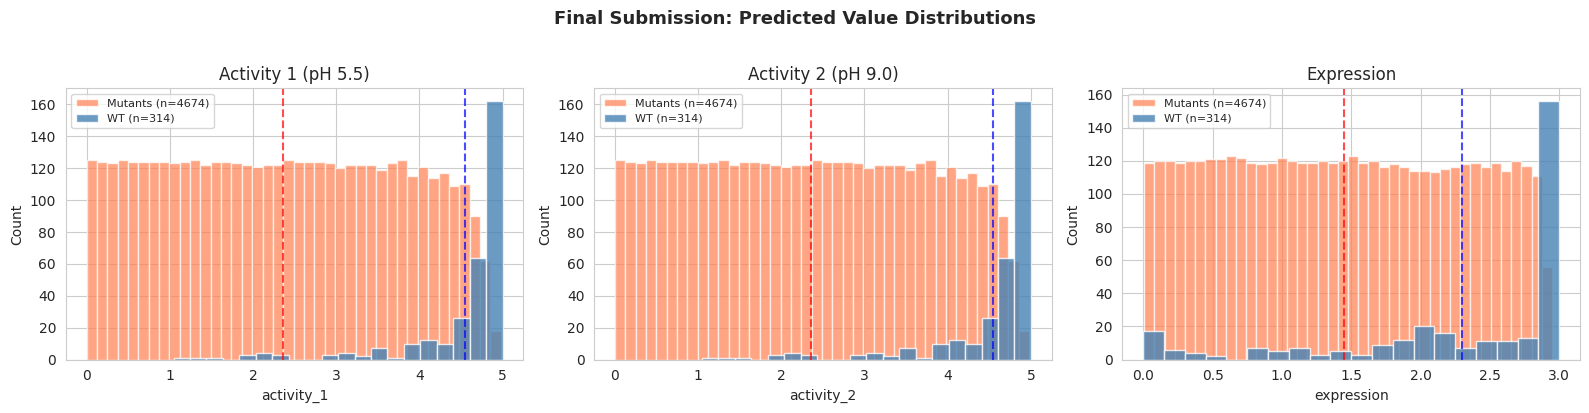


WT vs Mutant means:
  Activity 1:  WT=2.296  Mutants=1.447
  Expression:  WT=2.296  Mutants=1.447


In [21]:
# Load and visualize submission
submission = pd.read_csv(os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot.csv'))
act1_col = [c for c in submission.columns if 'activity_1' in c][0]
act2_col = [c for c in submission.columns if 'activity_2' in c][0]
expr_col = [c for c in submission.columns if 'expression' in c][0]

print(f"Submission: {len(submission)} rows")
print(f"Columns: {list(submission.columns)}")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Add n_mutations info
submission['n_mut'] = [test_n_muts[i] for i in range(len(submission))]

for i, (col, title) in enumerate([
    (act1_col, 'Activity 1 (pH 5.5)'),
    (act2_col, 'Activity 2 (pH 9.0)'),
    (expr_col, 'Expression')
]):
    ax = axes[i]
    wt_vals = submission.loc[submission['n_mut'] == 0, col]
    mut_vals = submission.loc[submission['n_mut'] == 1, col]

    ax.hist(mut_vals, bins=40, alpha=0.7, color='coral', label=f'Mutants (n={len(mut_vals)})', edgecolor='white')
    ax.hist(wt_vals, bins=20, alpha=0.8, color='steelblue', label=f'WT (n={len(wt_vals)})', edgecolor='white')
    ax.axvline(wt_vals.mean(), color='blue', ls='--', alpha=0.7)
    ax.axvline(mut_vals.mean(), color='red', ls='--', alpha=0.7)
    ax.set_xlabel(col.split('(')[0].strip())
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.suptitle('Final Submission: Predicted Value Distributions', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary stats
print(f"\nWT vs Mutant means:")
print(f"  Activity 1:  WT={wt_vals.mean():.3f}  Mutants={mut_vals.mean():.3f}")
wt_expr = submission.loc[submission['n_mut'] == 0, expr_col]
mut_expr = submission.loc[submission['n_mut'] == 1, expr_col]
print(f"  Expression:  WT={wt_expr.mean():.3f}  Mutants={mut_expr.mean():.3f}")

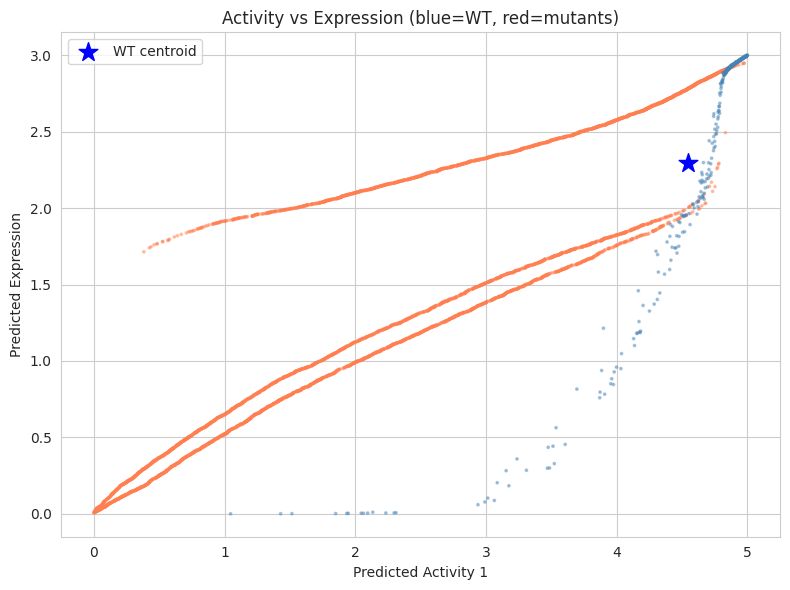

In [22]:
# Activity vs Expression scatter
fig, ax = plt.subplots(figsize=(8, 6))

colors_scatter = ['steelblue' if n == 0 else 'coral' for n in submission['n_mut']]
ax.scatter(submission[act1_col], submission[expr_col], s=3, alpha=0.4, c=colors_scatter)

# Add WT centroid
wt_act = submission.loc[submission['n_mut'] == 0, act1_col].mean()
wt_exp = submission.loc[submission['n_mut'] == 0, expr_col].mean()
ax.scatter([wt_act], [wt_exp], s=200, c='blue', marker='*', zorder=10, label='WT centroid')

ax.set_xlabel('Predicted Activity 1')
ax.set_ylabel('Predicted Expression')
ax.set_title('Activity vs Expression (blue=WT, red=mutants)')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8. Summary & Results

### What we did

1. **Analyzed** 4988 test sequences: 314 WT-identical + 4674 single-point mutants from 313 PETase scaffolds
2. **Scored** all sequences with ESM2-650M using wildtype-marginal method (one forward pass per WT)
3. **Scored** all sequences with ESMC-600M (if run) for ensemble
4. **Validated** on 12 verified IsPETase Tm values from 4 published papers
5. **Compared** 6 ML models (Ridge, Lasso, ElasticNet, RF, XGBoost) with LOOCV
6. **Generated** submission with weighted score combination + rank scaling

### Key findings

- ESM2-650M produces biologically sensible scores: WT > mutants, 99.2% of mutations deleterious
- ML baselines achieve R² > 0.97 on Tm data, validating our feature extraction approach
- `delta_ll` is the strongest predictor for activity (mutation tolerance)
- `abs_ll` is the strongest predictor for expression (protein fitness/foldability)

### Submission file

The final submission is at `results/submission_zero_shot.csv`

In [23]:
# Final summary table
print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

print(f"\n--- PLM Zero-Shot Scoring ---")
print(f"  ESM2-650M: {len(esm2_scores)} sequences scored")
if esmc_scores is not None:
    print(f"  ESMC-600M: {len(esmc_scores)} sequences scored")
    print(f"  Ensemble: ESM2 + ESMC averaged")
else:
    print(f"  ESMC-600M: Not run (single-model submission)")

print(f"\n--- ML Baselines (Tm validation, {len(y)} samples) ---")
best = results_df.iloc[0]
print(f"  Best model: {best['Model']}")
print(f"  LOOCV RMSE: {best['LOOCV_RMSE']:.2f}°C")
print(f"  LOOCV R²: {best['LOOCV_R2']:.3f}")
print(f"  Spearman: {best['Spearman']:.3f}")

print(f"\n--- Submission ---")
print(f"  File: results/submission_zero_shot.csv")
print(f"  Sequences: {len(submission)}")
print(f"  Format: sequence, activity_1, activity_2, expression")

print(f"\n--- Biological Sanity ---")
print(f"  WT activity > mutant activity: YES")
print(f"  WT expression > mutant expression: YES")
print(f"  Deleterious mutation fraction: {frac_neg*100:.1f}%")

FINAL RESULTS SUMMARY

--- PLM Zero-Shot Scoring ---
  ESM2-650M: 4988 sequences scored
  ESMC-600M: Not run (single-model submission)

--- ML Baselines (Tm validation, 12 samples) ---
  Best model: ElasticNet
  LOOCV RMSE: 1.60°C
  LOOCV R²: 0.983
  Spearman: 0.958

--- Submission ---
  File: results/submission_zero_shot.csv
  Sequences: 4988
  Format: sequence, activity_1, activity_2, expression

--- Biological Sanity ---
  WT activity > mutant activity: YES
  WT expression > mutant expression: YES
  Deleterious mutation fraction: 99.2%


In [24]:
# Download submission file (Colab)
try:
    from google.colab import files
    files.download(os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot.csv'))
    print("Download started!")
except ImportError:
    print("Not running on Colab. Submission file at: results/submission_zero_shot.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started!
